# 0. Setup

In [12]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import L2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'imagespng') # get the path of image folder

# gpu setup
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Plotting Functions

In [13]:
# plot relationship between real and predicted values
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


# plot a metric from the given model training history
def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

# 1.1 - Load and Process Metadata

In [14]:
# read metadata, drop target columns, original image size information and study description (natural language)
# fill unknown values of body part examined with 'UNKNOWN'
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')

# one hot encode the remaining columns, drop original columns and redundant columns
mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
hbit_dummies = pd.get_dummies(df.HighBit)
df = pd.concat([df, hbit_dummies, mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'HighBit', 7, 'XA','UNKNOWN'])

# read metadata and drop all columns except target labels - WindowWidth and WindowCenter
labels_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
labels_df = labels_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# format numbers - find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
labels_df = labels_df.applymap(extract_number_from_list)

# convert string values to float32
labels_df['WindowCenter'] = labels_df['WindowCenter'].astype('float32')
labels_df['WindowWidth'] = labels_df['WindowWidth'].astype('float32')

# scale numeric values to range from 0 to 255
labels_df['WindowCenter'] = np.maximum(np.array(labels_df['WindowCenter']), 0) / np.array(labels_df['WindowCenter']).max() * 255.0
labels_df['WindowWidth'] = np.maximum(np.array(labels_df['WindowWidth']), 0) / np.array(labels_df['WindowWidth']).max() * 255.0


# some images are completely black and contain only zero values, they will be removed from dataframes
# load image and drop row from dataframe if the image contains only zeroes (black)
def remove_black_images(df):
    for id in df.index:
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        #some images only contain 0 values, even in original npy file and will be ignored in the dataset
        if (not(np.min(img) == np.max(img) == 0)):
            df.drop(id)

    return df

df = remove_black_images(df)
labels_df = remove_black_images(labels_df)

# 2. Create and Format Datasets

In [15]:
# load png images using dataframe index as file names and return a numpy array of images
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        # 1 grayscale dimension is dropped by default so it's added back manually
        img = np.expand_dims(img, -1) 

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img


# format datasets - return tuple of labels as arrays
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width


# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# select a random state seed for more repeatable results
split_seed = 9 # determined as best experimentally from 1 to 50, better split option might exist

# train - test split
x_train, x_test, y_train, y_test = train_test_split(df, labels_df, test_size=1-train_ratio, random_state=split_seed)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=split_seed)

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

# extract image from dataframe
x_train_img = get_image(x_train)
x_val_img = get_image(x_val)
x_test_img = get_image(x_test)

# metadata split into separate arrays for easier removal later
def format_metadata(data):
    highbit = data[[9, 11, 15]]
    modalities = data[['CT', 'CR', 'MR', 'NM', 'RF']] 
    bpe = data.drop(columns=[9, 11, 15, 'CT', 'CR', 'MR', 'NM', 'RF'])

    return np.array(highbit), np.array(modalities), np.array(bpe)

x_train_hbit, x_train_mod, x_train_bpe = format_metadata(x_train)
x_val_hbit, x_val_mod, x_val_bpe = format_metadata(x_val)
x_test_hbit, x_test_mod, x_test_bpe = format_metadata(x_test)

# x_train means
train_means = np.mean(x_train_img)
train_stddev = np.std(x_train_img)
def image_scaler(images):
    return (images - train_means) / train_stddev

# 3. ALL METADATA - BASELINE MODEL

In [16]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'


def build_mi_model():
    # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))

    input_hbit = Input(shape=(3,))
    input_mod = Input(shape=(5,))
    input_bpe = Input(shape=(27,))
    metadata = keras.layers.concatenate([input_hbit, input_mod, input_bpe])


    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Flatten() (x)

     # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
 
    
    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_hbit, input_mod, input_bpe], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()

# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=0.0001)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}


mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

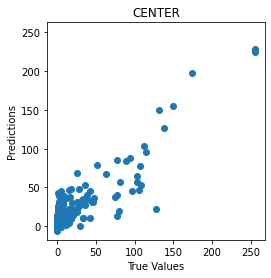

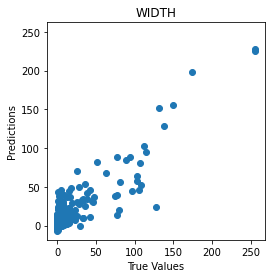

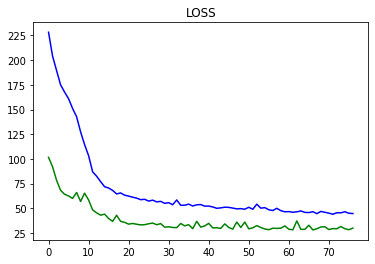

The accuracy of WindowCenter is 85.0%
The accuracy of WindowWidth is 81.0%
Mean absolute error of WindowCenter is 1.6299999952316284
Mean absolute error of WindowWidth is 1.9700000286102295
Mean squared error of WindowCenter is 16.329999923706055, RMSE: 4.039999961853027
Mean squared errory of WindowWidth is 19.06999969482422, RMSE: 4.369999885559082


In [17]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_hbit, x_train_mod, x_train_bpe], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_hbit, x_val_mod, x_val_bpe], y_val), verbose=0, callbacks=[stop_early_mi])

# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_hbit, x_test_mod, x_test_bpe])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

# 4. ABLATION STUDY - Effect of Metadata

## HighBit + Modality

In [18]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():

    # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))

    input_hbit = Input(shape=(3,))
    input_mod = Input(shape=(5,))
    metadata = keras.layers.concatenate([input_hbit, input_mod])
    

    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    

    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 

    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_hbit, input_mod], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()


# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

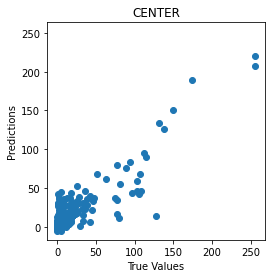

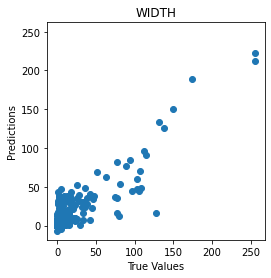

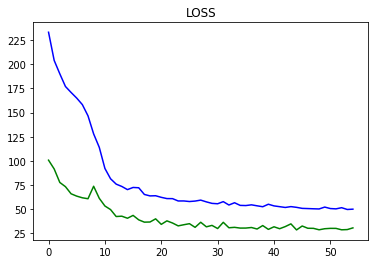

The accuracy of WindowCenter is 84.0%
The accuracy of WindowWidth is 79.0%
Mean absolute error of WindowCenter is 1.559999942779541
Mean absolute error of WindowWidth is 1.9600000381469727
Mean squared error of WindowCenter is 18.200000762939453, RMSE: 4.269999980926514
Mean squared errory of WindowWidth is 21.1200008392334, RMSE: 4.599999904632568


In [19]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_hbit, x_train_mod], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_hbit, x_val_mod], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_hbit, x_test_mod])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

## HighBit + BodyPartExamined

In [20]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():
     # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))

    input_hbit = Input(shape=(3,))
    input_bpe = Input(shape=(27,))
    metadata = keras.layers.concatenate([input_hbit, input_bpe])


    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    

    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 


    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_hbit, input_bpe], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()

# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

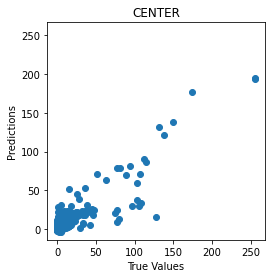

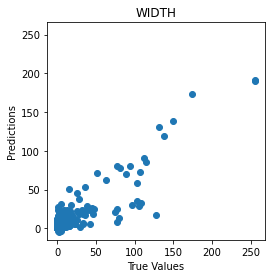

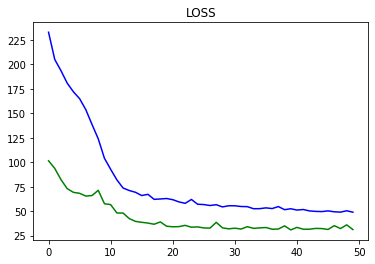

The accuracy of WindowCenter is 82.0%
The accuracy of WindowWidth is 78.0%
Mean absolute error of WindowCenter is 1.8200000524520874
Mean absolute error of WindowWidth is 2.0299999713897705
Mean squared error of WindowCenter is 19.579999923706055, RMSE: 4.420000076293945
Mean squared errory of WindowWidth is 21.8799991607666, RMSE: 4.679999828338623


In [21]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_hbit, x_train_bpe], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_hbit, x_val_bpe], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_hbit, x_test_bpe])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

## Modality + BodyPartExamined

In [22]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():
    # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))

    input_mod = Input(shape=(5,))
    input_bpe = Input(shape=(27,))
    metadata = keras.layers.concatenate([input_mod, input_bpe])


    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    
    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
      
    
    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
              
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_mod, input_bpe], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()


# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

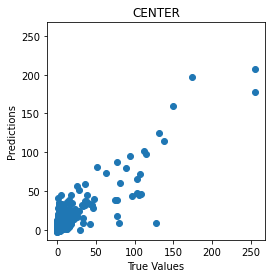

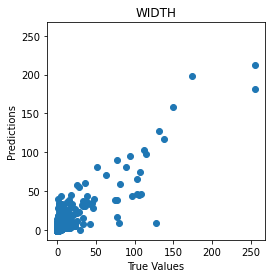

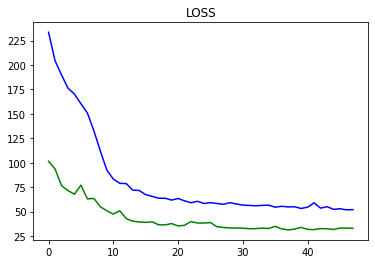

The accuracy of WindowCenter is 82.0%
The accuracy of WindowWidth is 78.0%
Mean absolute error of WindowCenter is 1.75
Mean absolute error of WindowWidth is 2.0199999809265137
Mean squared error of WindowCenter is 20.170000076293945, RMSE: 4.489999771118164
Mean squared errory of WindowWidth is 21.989999771118164, RMSE: 4.690000057220459


In [23]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_mod, x_train_bpe], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_mod, x_val_bpe], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_mod, x_test_bpe])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# Plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

## Only HighBit

In [25]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():
     # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))
    input_hbit = Input(shape=(3,))


    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)

    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (input_hbit) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
      
    
    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
              
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_hbit], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()


# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

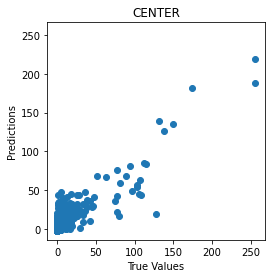

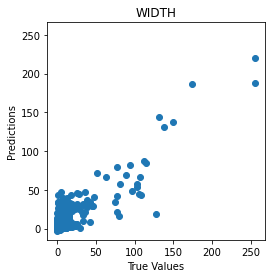

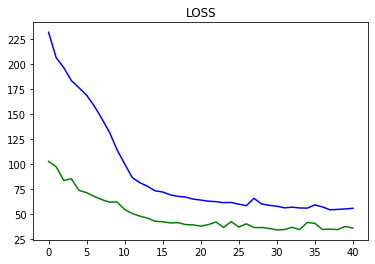

The accuracy of WindowCenter is 80.0%
The accuracy of WindowWidth is 76.0%
Mean absolute error of WindowCenter is 2.059999942779541
Mean absolute error of WindowWidth is 2.309999942779541
Mean squared error of WindowCenter is 21.989999771118164, RMSE: 4.690000057220459
Mean squared errory of WindowWidth is 24.09000015258789, RMSE: 4.909999847412109


In [26]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_hbit], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_hbit], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_hbit])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

## Only Modality

In [27]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():
     # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))
    input_mod = Input(shape=(5,))


     # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    
    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (input_mod) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
      
   
    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
              
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_mod], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()


# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

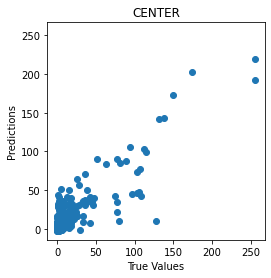

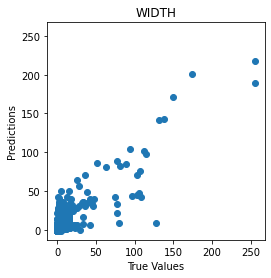

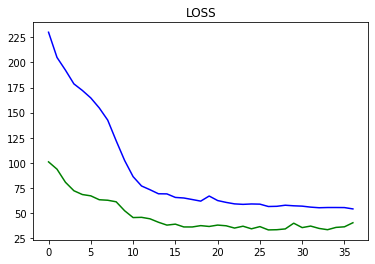

The accuracy of WindowCenter is 81.0%
The accuracy of WindowWidth is 76.0%
Mean absolute error of WindowCenter is 1.840000033378601
Mean absolute error of WindowWidth is 2.1700000762939453
Mean squared error of WindowCenter is 21.559999465942383, RMSE: 4.639999866485596
Mean squared errory of WindowWidth is 24.170000076293945, RMSE: 4.920000076293945


In [28]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_mod], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_mod], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_mod])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')


# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

## Only BodyPartExamined

In [29]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'

def build_mi_model():
    # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))
    input_bpe = Input(shape=(27,))

    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    

    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (input_bpe) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
      
    
    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
              
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_bpe], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()


# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

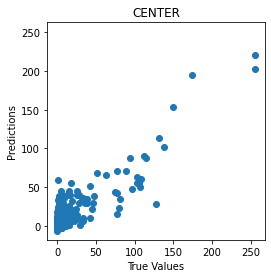

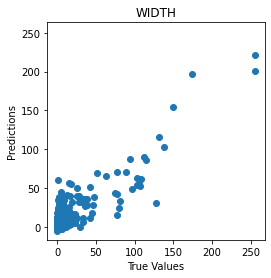

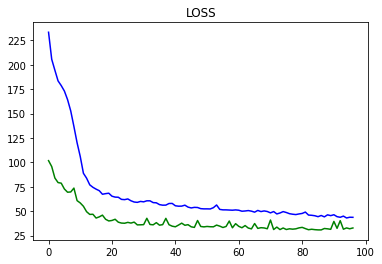

The accuracy of WindowCenter is 82.0%
The accuracy of WindowWidth is 78.0%
Mean absolute error of WindowCenter is 1.8899999856948853
Mean absolute error of WindowWidth is 2.109999895095825
Mean squared error of WindowCenter is 20.31999969482422, RMSE: 4.510000228881836
Mean squared errory of WindowWidth is 21.790000915527344, RMSE: 4.670000076293945


In [30]:
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_bpe], 
                          y = y_train, batch_size=256, epochs=100, 
                          validation_data=([image_scaler(x_val_img), x_val_bpe], y_val), verbose=0, callbacks=[stop_early_mi])


# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_bpe])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))